# Project : Analysing bagging

#### Authors: HUANG Kaixian

## Aim

The aim of this project is building a regression model in which the advantage of bagging should be demonstrated empirically

## Part 0 : Introduction

### What is bagging?

**Definition** (bootstrap aggregating): 

An ensemble method using bootstrap to resample datasets then aggregating the several estimators, which is computationally intensive, but can improve unstable estimation or classification schemes.

**Algorithm:** (Show in the figure below)

- 1) Draw bootstrap samples $(Z_{n,i}^{*})_{i=1,\cdots,n}$, according to the empirical distribution $P_n$ of the original samples.
- 2) Compute the bootstrapped estimator $\hat{\theta_{n}^{*}}(x)$
- 3) Compute the expectation as the bagged estimator $\hat{\theta_{B}}(x)= \mathbb{E}^{*}[\hat{\theta_{n}^{*}}(x)]$

**Remark:** In practice, we use Monte carlo to get an approximate estimator of the bagged estimator
$$\hat{\theta}_{MC}(x) = \frac{1}{m}\sum_{i = 1}^{m}\hat{\theta}_{n,i}^{*}(x)$$

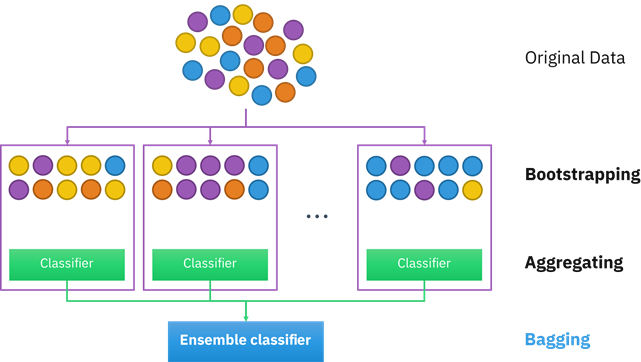

**Advantages:**

- 1) Drastic variance reduction when predictor is unstable.
- 2) Bias are roughly unchanged

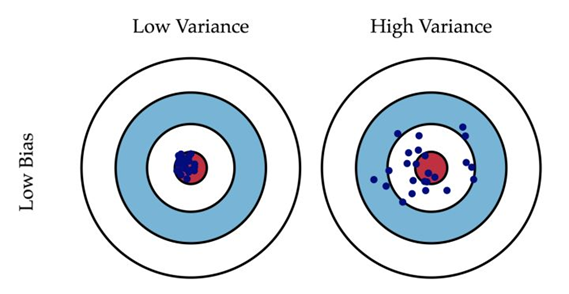

## Part 1 : Toy Example

### Goal

Determine if the mean of random varibele $y_i$ is small of large than x.

the naive estimator is:
$$\hat{\theta}(x) = 1_{\bar{y_n} \leq x}$$
the bagging estimator is:
$$\mathbb{E}^{*}[\hat{\theta}(x)]$$

Theoretically, $\hat{\theta}(x) \sim Bernoulli(\Phi(c))$ and $\mathbb{E}^{*}[\hat{\theta}(x)] \sim \Phi(c-z)$

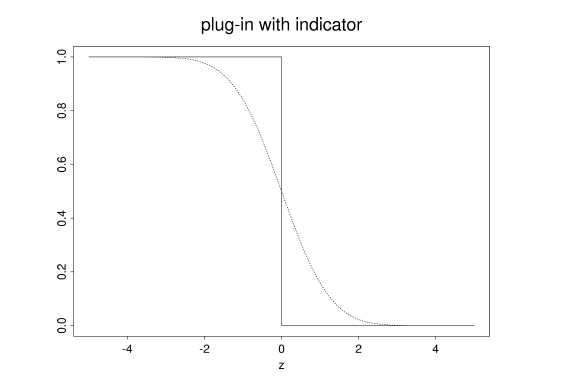

Theoretically, Bagging variance is always smaller

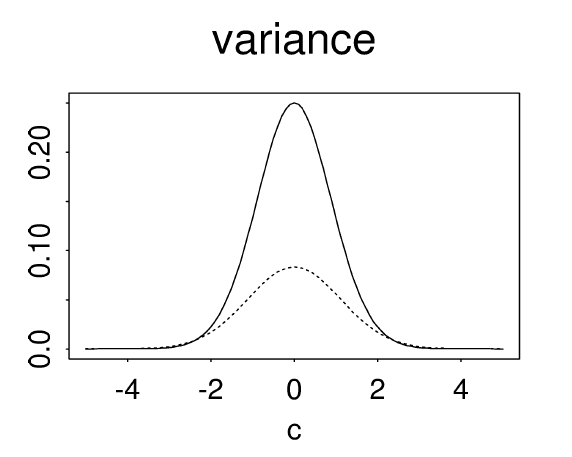

### Numerically prove the results with synthesis data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def indicator(y_hat,x): # indicator function
    if y_hat < x:
        return 1
    else:
        return 0

In [2]:
n = 500 # times to simulate distribution
Samples = 1000 # sample numbers
mu = 0 # mean
sigma = 1 # stardard deviation

In [3]:
c = 0
x = mu + c*sigma*Samples**(-1/2)

In [4]:
theta_hat = []
Z = []
for i in range(n):
    y = np.random.normal(mu, sigma, Samples)
    y_hat = np.mean(y)
    theta_hat.append(indicator(y_hat,x))
    Z.append((y_hat-mu)*Samples**(1/2)/sigma)

Text(0, 0.5, 'theta_hat')

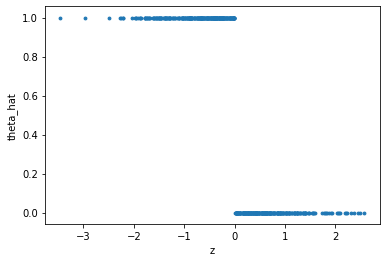

In [5]:
plt.scatter(Z,theta_hat,s=8)
plt.xlabel('z')
plt.ylabel('theta_hat')

In [6]:
theta_hat_bagging = []
Z_bagging = []
for i in range(n):
    m = 100
    y = np.random.normal(mu, sigma, Samples)
    theta_bagging = []
    for i in range(m):
        y_ = np.random.choice(y,Samples)
        y_hat_ = np.mean(y_)
        theta_bagging.append(indicator(y_hat_,x))
    theta_hat_bagging.append(np.mean(theta_bagging))
    Z_bagging.append((np.mean(y)-mu)*Samples**(1/2)/sigma)

Text(0, 0.5, 'theta_hat')

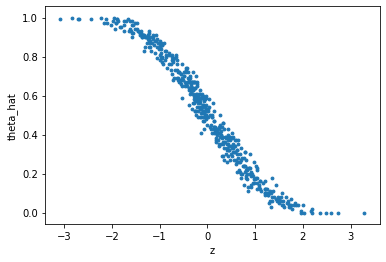

In [7]:
plt.scatter(Z_bagging,theta_hat_bagging,s=8)
plt.xlabel('z')
plt.ylabel('theta_hat')

### Comment:
Compare the numerical figure and theoretical figures:
- the results match theoretical the property and trendency
- bagging indeed soft the hard decision

#### Now, we will show the variance of two estimator.

In [8]:
k = 201 # rhe numbers of c for the plot
c = np.linspace(-4,4,k)

n = 500 # times to simulate distribution
Samples = 1000 # sample numbers
mu = 0 # mean
sigma = 1 # stardard deviation

In [9]:
def variance():
    var = []
    for i in range(k):
        x = mu + c[i]*sigma*Samples**(-1/2)
        theta_hat = []
        for j in range(n):
            y = np.random.normal(mu, sigma, Samples)
            y_hat = np.mean(y)
            theta_hat.append(indicator(y_hat,x))
        var.append(np.mean((theta_hat - np.mean(theta_hat))**2))
    return var

In [10]:
var_ = variance()

Text(0, 0.5, 'variance')

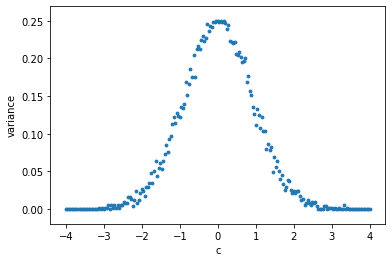

In [11]:
plt.scatter(c,var_,s=8)
plt.xlabel('c')
plt.ylabel('variance')

In [12]:
from numba import njit

@njit
def variance_bagging():
    k = 201 
    c = np.linspace(-4,4,k)
    m = 50
    n = 500
    Samples = 1000 
    mu = 0 
    sigma = 1 
    var = np.zeros(k)
    for i in range(k):
        x = mu + c[i]*sigma*Samples**(-1/2)
        theta_hat_bagging = np.zeros(n)
        for j in range(n):
            y = np.random.normal(mu, sigma, Samples)
            theta_bagging = np.zeros(m)
            for k in range(m):
                y_ = np.random.choice(y,Samples)
                y_hat_ = np.mean(y_)
                if y_hat_ < x:
                    theta_bagging[k] = 1
                else:
                    theta_bagging[k] = 0
            theta_hat_bagging[j] = np.mean(theta_bagging)
        var[i] = np.mean((theta_hat_bagging - np.mean(theta_hat_bagging))**2)
    return var

In [13]:
var = variance_bagging()

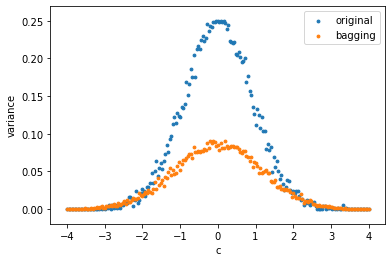

In [14]:
plt.scatter(c,var_,s=8,label="original")
plt.scatter(c,var,s=8,label="bagging")
plt.xlabel('c')
plt.ylabel('variance')
plt.legend()
plt.show()

### Comment:
Compare the numerical figure and theoretical figures:
- variance of bagging is smaller than the original one.
- when c is large the variance is close to 0

## Part 2 : linear regression example

### Goal

Show in linear regression model, bagging also acts as smoothing or softening and leads to a reduced variance without much sacrifice on the bias

$$Y_i = (X\beta)_i + \epsilon_i \quad (i =1,\cdots,n)$$

where X are orthogonal (in expectation):

$$E(X^TX) = I$$

Text(0.5, 1.0, 'Parameters / Coefficients')

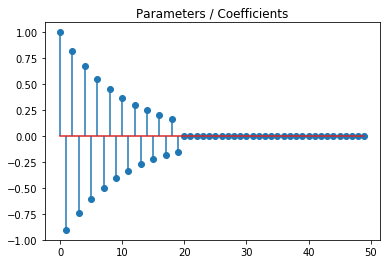

In [15]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs,use_line_collection=True)
plt.title("Parameters / Coefficients")

In [16]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

def simu_linreg(coefs, n_samples=1000, corr=0.1):
    """Simulation of a linear regression model
    """
    # Construction of a covariance matrix
    if corr ==0:
        cov = np.eyes(n_features)
    else:
        cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

In [17]:
X, y = simu_linreg(coefs)

The least square estimator is:
$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

and $\hat{\beta}$ is then asymptotically normally distributed at rate $n^{-1/2}$

$$\hat{\beta} = (X^TX)^{-1}X^T(X\beta + \epsilon)$$
$$\hat{\beta} = \beta + (X^TX)^{-1}X^T\epsilon$$

In [18]:
from scipy import linalg
beta = linalg.inv(X.T @ X) @ X.T @ y

Text(0.5, 1.0, 'Parameters / Coefficients')

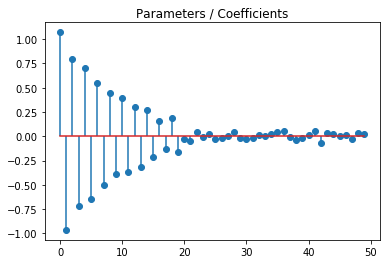

In [19]:
plt.stem(beta,use_line_collection=True)
plt.title("Parameters / Coefficients")

As we can see, the beta is not sparse like the groundtruth,because the normally noises, **In this case we need to using testing to verify whether we should to reserve a components of the coefs.**

In [20]:
from scipy.stats import t
sigma = np.sqrt(np.mean((y- X @ beta)**2))
t_ = t.ppf(0.975,df=n_samples-1)
Z  = np.sum(X**2,axis=0)
u_n = t_ * sigma / np.sqrt(Z)

Text(0.5, 1.0, 'Parameters / Coefficients')

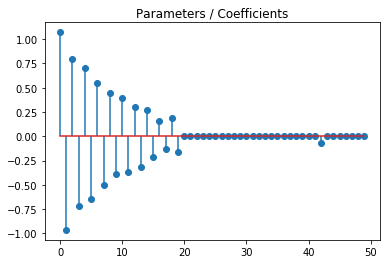

In [21]:
beta_ = np.zeros_like(beta)
idx = np.where(np.abs(beta)>u_n)[0]
beta_[idx] = beta[idx]
plt.stem(beta_,use_line_collection=True)
plt.title("Parameters / Coefficients")

we can select the good features, then we will test $\beta = b\sigma n^{-1/2}$

Text(0.5, 1.0, 'Parameters / Coefficients')

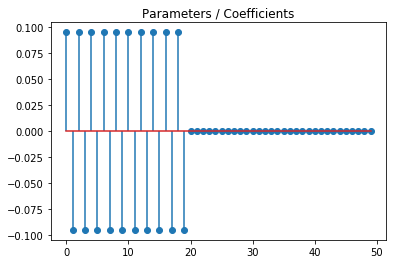

In [22]:
n_features = 50
n_samples = 1000
sigma = 1
b = 3
idx = np.arange(n_features)
coefs = ((-1) ** idx)*b*sigma*n_samples**(-1/2)
coefs[20:] = 0
plt.stem(coefs,use_line_collection=True)
plt.title("Parameters / Coefficients")

In [23]:
X, y = simu_linreg(coefs)

Text(0.5, 1.0, 'Parameters / Coefficients')

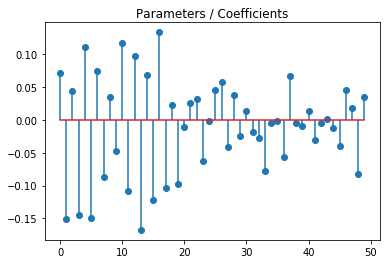

In [24]:
beta = linalg.inv(X.T @ X) @ X.T @ y
plt.stem(beta,use_line_collection=True)
plt.title("Parameters / Coefficients")

Text(0.5, 1.0, 'Parameters / Coefficients')

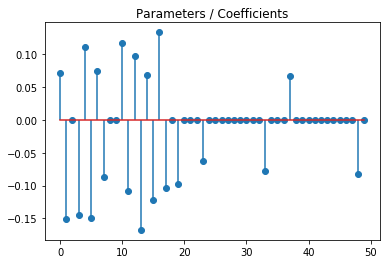

In [25]:
sigma = np.sqrt(np.mean((y- X @ beta)**2))
t_ = t.ppf(0.975,df=n_samples-1)
Z  = np.sum(X**2,axis=0)
u_n = t_ * sigma / np.sqrt(Z)
beta_ = np.zeros_like(beta)
idx = np.where(np.abs(beta)>u_n)[0]
beta_[idx] = beta[idx]
plt.stem(beta_,use_line_collection=True)
plt.title("Parameters / Coefficients")

As we can see we coefs are close to the $\beta = \sigma$, the selection is not stable at all

**Then we will test bagging**

Text(0.5, 1.0, 'Parameters / Coefficients')

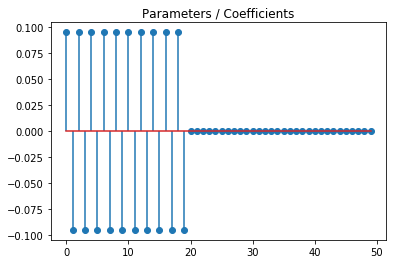

In [26]:
n_features = 50
n_samples = 1000
sigma = 1
b = 3
idx = np.arange(n_features)
coefs = ((-1) ** idx)*b*sigma*n_samples**(-1/2)
coefs[20:] = 0
plt.stem(coefs,use_line_collection=True)
plt.title("Parameters / Coefficients")

**Then we will test bagging**

In [27]:
X, y = simu_linreg(coefs)

In [28]:
coefs_=np.zeros(n_features)
index_ = []
m = 100
for i in range(m):
    index = np.random.randint(0,n_samples,n_samples)
    X_ = X[index]
    y_ =y[index]
    beta = linalg.inv(X_.T @ X_) @ X_.T @ y_
    sigma = np.sqrt(np.mean((y_- X_ @ beta)**2))
    t_ = t.ppf(0.975,df=n_samples-1)
    Z  = np.sum(X_**2,axis=0)
    u_n = t_ * sigma / np.sqrt(Z)
    beta_ = np.zeros_like(beta)
    idx = np.where(np.abs(beta)>u_n)[0]
    beta_[idx] = beta[idx]
    index_.append(idx)
    coefs_ += beta_

In [29]:
out = np.zeros(n_features)
for i in range(m):
    out[index_[i]]+=1

Text(0.5, 1.0, 'Parameters / Coefficients')

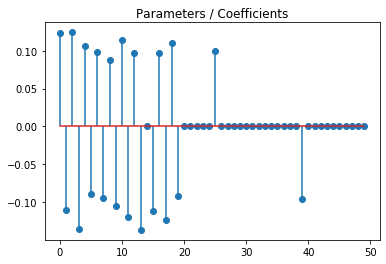

In [30]:
position = np.where(out>=m/2)[0]
final=np.zeros(n_features)
final[position]=coefs_[position]/out[position]
plt.stem(final,use_line_collection=True)
plt.title("Parameters / Coefficients")

### Comment:
Compare the numerical figure and theoretical figures:
- we can select the proper features.
- Bagging estimator is more stable

## Part 3 : Decision tree  and Random forest (Classification)

### Goal

Use real data and decision tree (random forest)for classification task, compare the stability of the two algoritm.

Real dataset contains :

  - 21 features 
  - the label to predict : if the patient has a normal judged thyroid or if he suffers from hyper or hypothyroidism.

The dataset has been found on https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/.

In [31]:
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,fbeta_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import pandas as pd


def get_train_data(path="."):
    return pd.read_csv(path + "/data/train.csv")

def get_test_data(path="."):
    return pd.read_csv(path + "/data/test.csv")

# The accuracy is not good, because the dataset is too skewed,the accuracy is always wery high
# So I define my own score for it.
def Score(y, y_pred):
    my_score = f1_score(y_true=y, y_pred=y_pred, labels=[1, 2], average=None)
    f_beta_score = fbeta_score(y_true=y, y_pred=y_pred, beta=0.95, labels=[3], average=None)
    res =(my_score[0] + my_score[1] + f_beta_score[0])/3
    return res

X_train = get_train_data()
X_test = get_test_data()
y_train, y_test = X_train['disease'], X_test['disease']

# In Here we just choose several features.
cols = ["age", "TSH", "T3", "TT4", "T4U", "FTI"]
ct = make_column_transformer(('passthrough', cols))

In [32]:
score = []
clf=tree.DecisionTreeClassifier(class_weight="balanced")
clf

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Text(0.5, 0, 'Score')

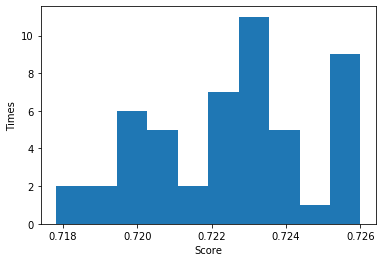

In [33]:
pipe = make_pipeline(ct, clf)
for i in range(50):
    pipe.fit(X_train, y_train)
    Y = pipe.predict(X_test)
    score.append(Score(y_test,Y))
plt.hist(score)  
plt.ylabel('Times')
plt.xlabel('Score')

In [34]:
from sklearn.ensemble import RandomForestClassifier
score = []
clf = RandomForestClassifier(n_estimators=50,
                             class_weight="balanced_subsample",random_state=0)
clf

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

Text(0.5, 0, 'Score')

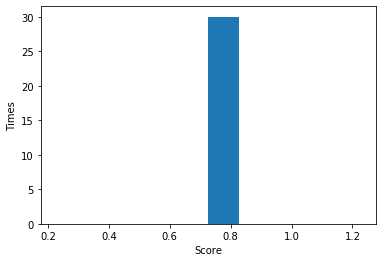

In [35]:
pipe = make_pipeline(ct, clf)
for i in range(30):
    pipe.fit(X_train, y_train)
    Y = pipe.predict(X_test)
    score.append(Score(y_test,Y))
plt.hist(score)  
plt.ylabel('Times')
plt.xlabel('Score')

### Comment:
Compare the two histogram of score
- Variance of RandomForest is smaller than the DecisionTree, and the score is higher
- We can notice that the the majority of the score value(RF) is concentrated in a small region ewen don't change, but DT is unstable.